In [1]:
import pyspark.sql.functions as sf
import pandas as pd
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [2]:
# Create pandas DataFrame
df_pd = pd.read_csv("metadata_output/combined_metadata.csv")

In [3]:
# Create Spark DataFrame
spark = SparkSession.builder.appName("Data Analysis App").getOrCreate()
df_sp = spark.read.csv('metadata_output/combined_metadata.csv', header=True, inferSchema=True)

3.1 Descriptive Statistics

In [4]:
# 1. What is the average duration (in seconds) of all videos in the dataset?
average_duration_pd = df_pd["duration_seconds"].mean()
print(f"[Pandas] Average duration of all videos: {average_duration_pd:.2f} seconds")

average_duration_sp = df_sp.select(sf.mean("duration_seconds"))
print("[Spark] Average duration of all videos:")
average_duration_sp.show()


[Pandas] Average duration of all videos: 1508.36 seconds
[Spark] Average duration of all videos:
+---------------------+
|avg(duration_seconds)|
+---------------------+
|   1508.3636363636363|
+---------------------+



In [5]:
# 2. Which uploader appears most frequently in the dataset?
mode_uploader_pd = df_pd["uploader"].mode()
print(f"[Pandas] Most frequent uploader: {mode_uploader_pd[0]}")

mode_uploader_sp = df_sp.groupBy("uploader").count().orderBy(sf.desc("count")).limit(1)
print("[Spark] Most frequent uploader:")
mode_uploader_sp.show()

[Pandas] Most frequent uploader: Chappell Roan
[Spark] Most frequent uploader:
+-------------+-----+
|     uploader|count|
+-------------+-----+
|Chappell Roan|    2|
+-------------+-----+



In [6]:
# 3. Which five videos have the highest number of views? List their titles and view counts.
top_views_pd = df_pd.nlargest(5, "view_count")[["title", "view_count"]]
print(f"[Pandas] Top 5 videos by view count: {top_views_pd.to_string(index=False)}")

top_views_sp = df_sp.select("title", "view_count").orderBy(sf.desc("view_count")).limit(5)
print("[Spark] Top 5 videos by view count:")
top_views_sp.show()

[Pandas] Top 5 videos by view count:                                                       title  view_count
      Chappell Roan - Pink Pony Club (Official Music Video)    78618729
Fleetwood Mac - Silver Springs (Live) (Official Video) [HD]    48786565
                   Mozart - Classical Music for Brain Power    41299056
     Charlie Chaplin - Final Speech from The Great Dictator     9749956
           Chappell Roan - The Giver (Official Lyric Video)     7319955
[Spark] Top 5 videos by view count:
+--------------------+----------+
|               title|view_count|
+--------------------+----------+
|Chappell Roan - P...|  78618729|
|Fleetwood Mac - S...|  48786565|
|Mozart - Classica...|  41299056|
|Charlie Chaplin -...|   9749956|
|Chappell Roan - T...|   7319955|
+--------------------+----------+



In [7]:
# 4. For each upload year, what is the average number of likes?
average_likes_per_year_pd = df_pd.groupby("year_uploaded")["like_count"].mean().reset_index()
average_likes_per_year_pd = average_likes_per_year_pd.sort_values(by="like_count", ascending=False)
print(f"[Pandas] Average likes per upload year:\n{average_likes_per_year_pd.to_string(index=False)}")

average_likes_per_year_sp = df_sp.groupBy("year_uploaded").agg(sf.mean("like_count").alias("average_likes"))
average_likes_per_year_sp = average_likes_per_year_sp.orderBy(sf.desc("average_likes"))
print("[Spark] Average likes per upload year:")
average_likes_per_year_sp.show()

[Pandas] Average likes per upload year:
 year_uploaded  like_count
          2020    704145.0
          2018    336813.0
          2016    270753.0
          2025    108272.0
          2022     19747.5
          2023      3899.5
          2019       811.0
[Spark] Average likes per upload year:
+-------------+-------------+
|year_uploaded|average_likes|
+-------------+-------------+
|         2020|     704145.0|
|         2018|     336813.0|
|         2016|     270753.0|
|         2025|     108272.0|
|         2022|      19747.5|
|         2023|       3899.5|
|         2019|        811.0|
+-------------+-------------+



In [8]:
# 5. How many videos are missing artist information?
missing_artist_count_pd = df_pd["artist"].isnull().sum()
print(f"[Pandas] Number of videos missing artist information: {missing_artist_count_pd}")

missing_artist_count_sp = df_sp.filter(sf.col("artist").isNull()).count()
print(f"[Spark] Number of videos missing artist information: {missing_artist_count_sp}")

[Pandas] Number of videos missing artist information: 11
[Spark] Number of videos missing artist information: 11


3.2 Tag and content characteristics

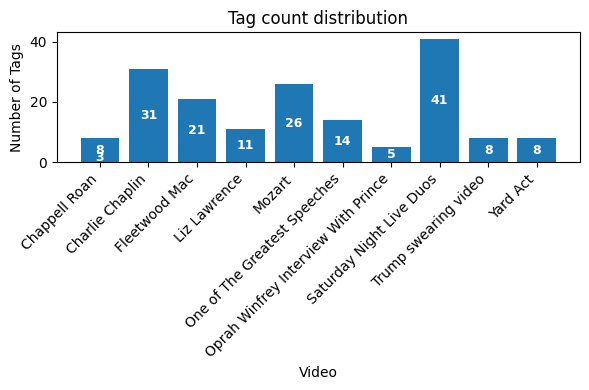

In [9]:
# 1. How many tags does each video have? Visualize the distribution using a histogram.
plt.figure(figsize=(6, 4))
bars = plt.bar(df_pd["legible_title"], df_pd['tag_count'])
plt.title("Tag count distribution")
plt.xlabel("Video")
plt.ylabel("Number of Tags")
plt.xticks(rotation=45, ha='right') 
plt.bar_label(
        bars,
        fmt='%d',
        label_type='center',
        color='white',
        fontsize=9,
        fontweight='bold'
    )
plt.tight_layout()
plt.show()

In [10]:
# 2. What is the total number of views per uploader? Rank the results in descending order.
total_views_per_uploader_pd = df_pd.groupby("uploader").agg(total_views=("view_count", "sum")
).reset_index()
total_views_per_uploader_pd = total_views_per_uploader_pd.sort_values(by="total_views", ascending=False)
print(f"[Pandas] Total views per uploader:\n{total_views_per_uploader_pd.to_string(index=False)}")

total_views_per_uploader_sp = df_sp.groupBy("uploader").agg(sf.sum("view_count").alias("total_views"))
total_views_per_uploader_sp = total_views_per_uploader_sp.orderBy(sf.desc("total_views"))
print("[Spark] Total views per uploader:")
total_views_per_uploader_sp.show()

[Pandas] Total views per uploader:
               uploader  total_views
          Chappell Roan     85938684
          Fleetwood Mac     48786565
           HALIDONMUSIC     41299056
        Charlie Chaplin      9749956
STILL I RISE Motivation      2270465
    Saturday Night Live      1266810
               Yard Act       826491
       lizlawrencemusic        49600
    FOX 29 Philadelphia        30102
            Mega Shortz         5520
[Spark] Total views per uploader:
+--------------------+-----------+
|            uploader|total_views|
+--------------------+-----------+
|       Chappell Roan|   85938684|
|       Fleetwood Mac|   48786565|
|        HALIDONMUSIC|   41299056|
|     Charlie Chaplin|    9749956|
|STILL I RISE Moti...|    2270465|
| Saturday Night Live|    1266810|
|            Yard Act|     826491|
|    lizlawrencemusic|      49600|
| FOX 29 Philadelphia|      30102|
|         Mega Shortz|       5520|
+--------------------+-----------+



In [11]:
# 3. Which video has the longest duration? List the title and its duration.
longest_video_pd = df_pd.loc[df_pd["duration_seconds"].idxmax(), ["title", "duration_seconds"]]
print(f"[Pandas] Longest video: {longest_video_pd['title']} with duration {longest_video_pd['duration_seconds']} seconds")

longest_video_sp = df_sp.orderBy(sf.desc("duration_seconds")).select("title", "duration_seconds").limit(1)
print("[Spark] Longest video:")
longest_video_sp.show()

[Pandas] Longest video: Mozart - Classical Music for Brain Power with duration 7342 seconds
[Spark] Longest video:
+--------------------+----------------+
|               title|duration_seconds|
+--------------------+----------------+
|Mozart - Classica...|            7342|
+--------------------+----------------+



In [12]:
# 4. How many videos were uploaded in each year? Present the results sorted by year.
videos_per_year_pd = df_pd["year_uploaded"].value_counts().reset_index()
videos_per_year_pd.columns = ["year_uploaded", "video_count"]
videos_per_year_pd = videos_per_year_pd.sort_values(by="year_uploaded")
print(f"[Pandas] Number of videos uploaded per year:\n{videos_per_year_pd.to_string(index=False)}")

videos_per_year_sp = df_sp.groupBy("year_uploaded").count().orderBy("year_uploaded")
print("[Spark] Number of videos uploaded per year:")
videos_per_year_sp.show()

[Pandas] Number of videos uploaded per year:
 year_uploaded  video_count
          2016            1
          2018            2
          2019            1
          2020            1
          2022            2
          2023            2
          2025            2
[Spark] Number of videos uploaded per year:
+-------------+-----+
|year_uploaded|count|
+-------------+-----+
|         2016|    1|
|         2018|    2|
|         2019|    1|
|         2020|    1|
|         2022|    2|
|         2023|    2|
|         2025|    2|
+-------------+-----+



In [13]:
# 5. Is there a correlation between the number of views and the number of likes? Feel free to drop or filter rows with missing or zero values before computing correlation.
correlation_pd = df_pd[["view_count", "like_count"]].dropna().corr().iloc[0, 1]

if correlation_pd > 0.8:
    assessment_pd = "strong positive correlation"
elif correlation_pd < -0.8:
    assessment_pd = "strong negative correlation"
else:
    assessment_pd = "weak or no correlation"

print(f"[Pandas] The correlation between views and likes is {correlation_pd:.2f}, this is a {assessment_pd}.")

correlation_sp = df_sp.select("view_count", "like_count").na.drop()
correlation_sp = correlation_sp.stat.corr("view_count", "like_count")

if correlation_sp > 0.8:
    assessment_sp = "strong positive correlation"
elif correlation_sp < -0.8:
    assessment_sp = "strong negative correlation"
else:
    assessment_sp = "weak or no correlation"
print(f"[Spark] The correlation between views and likes is {correlation_sp:.2f}, this is a {assessment_sp}.")

[Pandas] The correlation between views and likes is 0.94, this is a strong positive correlation.
[Spark] The correlation between views and likes is 0.94, this is a strong positive correlation.


3.3 Derived Metrics & Custom Analysis

In [14]:
# 1. Which video has the highest number of likes per second of duration?
highest_likes_per_second_pd = df_pd.assign(
    likes_per_second=lambda x: x["like_count"] / x["duration_seconds"]
).loc[df_pd["like_count"] > 0].nlargest(1, "likes_per_second")[["title", "likes_per_second"]]
print(f"[Pandas] Video with highest likes per second: {highest_likes_per_second_pd['title'].values[0]} with {highest_likes_per_second_pd['likes_per_second'].values[0]:.2f} likes/second.")

highest_likes_per_second_sp = df_sp.withColumn(
    "likes_per_second", sf.col("like_count") / sf.col("duration_seconds"))
highest_likes_per_second_sp = highest_likes_per_second_sp.filter(sf.col("like_count") > 0)
highest_likes_per_second_sp = highest_likes_per_second_sp.orderBy(sf.desc("likes_per_second")).select("title", "likes_per_second").limit(1)
print("[Spark] Video with highest likes per second:")
highest_likes_per_second_sp.show()

[Pandas] Video with highest likes per second: Chappell Roan - Pink Pony Club (Official Music Video) with 2514.80 likes/second.
[Spark] Video with highest likes per second:
+--------------------+------------------+
|               title|  likes_per_second|
+--------------------+------------------+
|Chappell Roan - P...|2514.8035714285716|
+--------------------+------------------+



In [15]:
# 2. Which uploader has the longest total duration of all their uploaded videos combined?
longest_total_duration_uploader_pd = df_pd.groupby("uploader")["duration_seconds"].sum().reset_index()
longest_total_duration_uploader_pd = longest_total_duration_uploader_pd.loc[longest_total_duration_uploader_pd["duration_seconds"].idxmax()]
print(f"[Pandas] Uploader with longest total duration: {longest_total_duration_uploader_pd['uploader']} with {longest_total_duration_uploader_pd['duration_seconds']} seconds.")

longest_total_duration_uploader_sp = df_sp.groupBy("uploader").agg(sf.sum("duration_seconds").alias("total_duration"))
longest_total_duration_uploader_sp = longest_total_duration_uploader_sp.orderBy(sf.desc("total_duration")).select("uploader", "total_duration").limit(1)
print("[Spark] Uploader with longest total duration:")
longest_total_duration_uploader_sp.show()

[Pandas] Uploader with longest total duration: HALIDONMUSIC with 7342 seconds.
[Spark] Uploader with longest total duration:
+------------+--------------+
|    uploader|total_duration|
+------------+--------------+
|HALIDONMUSIC|          7342|
+------------+--------------+



In [16]:
# 3. What is the ratio of views to likes for each video?
views_to_likes_ratio_pd = df_pd.assign(
    views_to_likes_ratio=lambda x: x["view_count"] / x["like_count"]
).loc[df_pd["like_count"] > 0][["title", "views_to_likes_ratio"]]
print(f"[Pandas] Views to likes ratio for each video:\n{views_to_likes_ratio_pd.to_string(index=False)}")

views_to_likes_ratio_sp = df_sp.withColumn(
    "views_to_likes_ratio", sf.col("view_count") / sf.col("like_count"))
views_to_likes_ratio_sp = views_to_likes_ratio_sp.filter(sf.col("like_count") > 0)
views_to_likes_ratio_sp = views_to_likes_ratio_sp.select("title", "views_to_likes_ratio")
print("[Spark] Views to likes ratio for each video:")
views_to_likes_ratio_sp.show(truncate=False)

[Pandas] Views to likes ratio for each video:
                                                                         title  views_to_likes_ratio
                         Chappell Roan - Pink Pony Club (Official Music Video)            111.651335
                              Chappell Roan - The Giver (Official Lyric Video)             33.836360
                        Charlie Chaplin - Final Speech from The Great Dictator             36.010519
                   Fleetwood Mac - Silver Springs (Live) (Official Video) [HD]            133.349091
                                             Liz Lawrence - None Of My Friends             61.159063
                                      Mozart - Classical Music for Brain Power            134.188050
One of The Greatest Speeches Ever by President Obama | Best Eye Opening Speech             81.995847
  Oprah Winfrey Interview With Prince Harry and Meghan Markle   Full Interview            262.857143
                                             